# Chapter 2

In [1]:
import arviz as az
import pymc as pm
import scipy.stats as stats

import matplotlib.pyplot as plt
import numpy as np

SEED = 42
rng = np.random.default_rng(SEED)

Code 2.1

In [ ]:
ways = np.array([0, 3, 8, 9, 0])
ways / ways.sum()

array([0.  , 0.15, 0.4 , 0.45, 0.  ])

Code 2.2

In [ ]:
stats.binom.pmf(6, n=9, p=0.5)

0.16406250000000003

Code 2.3 and 2.4

In [ ]:
def uniform_prior(grid_points):
    return np.repeat(5, grid_points)


def truncated_prior(grid_points, trunc_point=0.5):
    return (np.linspace(0, 1, grid_points) >= trunc_point).astype(int)


def double_exp_prior(grid_points):
    return np.exp(-5 * abs(np.linspace(0, 1, grid_points) - 0.5))

In [ ]:
def binom_post_grid_approx(prior, grid_points=5, success=6, tosses=9):
    # define grid
    p_grid = np.linspace(0, 1, grid_points)

    # define prior
    prior = prior(grid_points)

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(success, tosses, p_grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    return p_grid, posterior

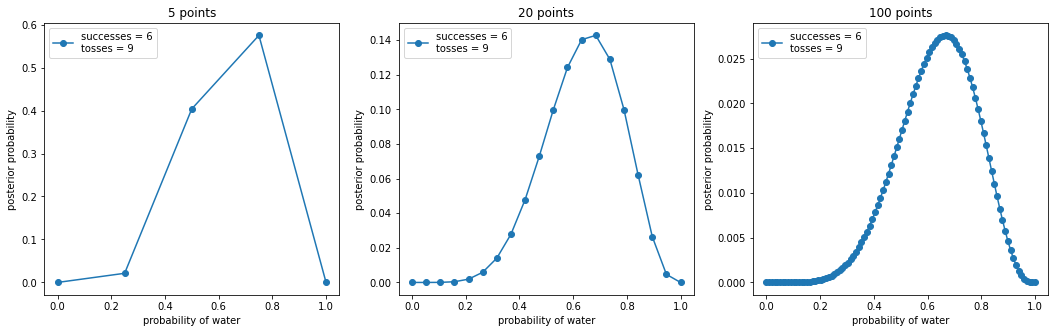

In [ ]:
w, n = 6, 9

points = (5, 20, 100)

_, ax = plt.subplots(1, len(points), figsize=(6 * len(points), 5))
for idx, ps in enumerate(points):
    p_grid, posterior = binom_post_grid_approx(uniform_prior, ps, w, n)
    ax[idx].plot(p_grid, posterior, "o-", label=f"successes = {w}\ntosses = {n}")
    ax[idx].set_xlabel("probability of water")
    ax[idx].set_ylabel("posterior probability")
    ax[idx].set_title(f"{ps} points")
    ax[idx].legend(loc=0)

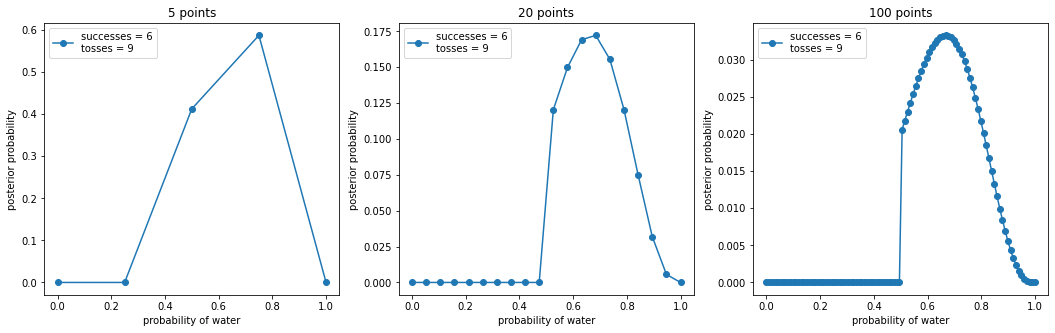

In [ ]:
_, ax = plt.subplots(1, len(points), figsize=(6 * len(points), 5))
for idx, ps in enumerate(points):
    p_grid, posterior = binom_post_grid_approx(truncated_prior, ps, w, n)
    ax[idx].plot(p_grid, posterior, "o-", label=f"successes = {w}\ntosses = {n}")
    ax[idx].set_xlabel("probability of water")
    ax[idx].set_ylabel("posterior probability")
    ax[idx].set_title(f"{ps} points")
    ax[idx].legend(loc=0)

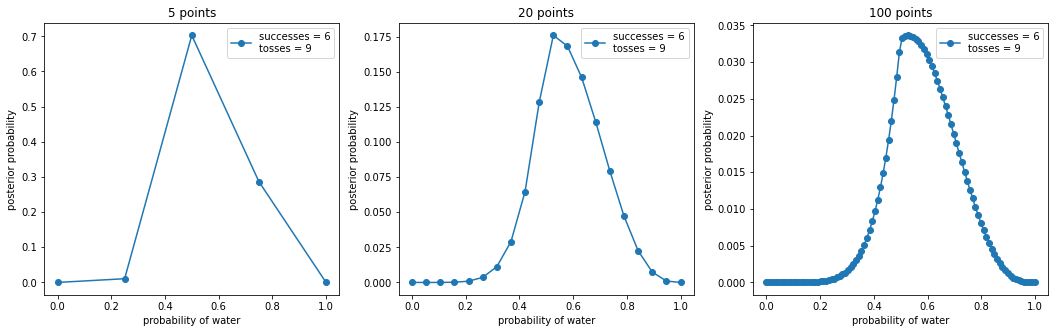

In [ ]:
_, ax = plt.subplots(1, len(points), figsize=(6 * len(points), 5))
for idx, ps in enumerate(points):
    p_grid, posterior = binom_post_grid_approx(double_exp_prior, ps, w, n)
    ax[idx].plot(p_grid, posterior, "o-", label=f"successes = {w}\ntosses = {n}")
    ax[idx].set_xlabel("probability of water")
    ax[idx].set_ylabel("posterior probability")
    ax[idx].set_title(f"{ps} points")
    ax[idx].legend(loc=0)

Code 2.5

## Code 2.6

Quadratic approximation (quap). 
Code taken from Ravin Kumar's [cheatsheet](https://ravinkumar.com/pages/InferenceCheatsheet.html).

In [18]:
data = np.repeat((0, 1), (3, 6))
data

array([0, 0, 0, 1, 1, 1, 1, 1, 1])

In [29]:
with pm.Model() as normal_approximation:
    # prior
    p = pm.Uniform("p", 0, 1) 
    # likelihood
    w = pm.Binomial("w", n=len(data), p=p, observed=data.sum())
    # inference
    mean_q = pm.find_MAP() # mean
    std_q = ((1/pm.find_hessian(mean_q, vars=[p]))**0.5)[0] # variance

print("Mean, Standard deviation\np {:.2}, {:.2}".format(mean_q["p"], std_q[0]))


Mean, Standard deviation
p 0.67, 0.64


In [5]:
# Compute the 89% percentile interval
norm = stats.norm(mean_q, std_q)
prob = 0.89
z = stats.norm.ppf([(1 - prob) / 2, (1 + prob) / 2])
pi = mean_q["prior"] + std_q * z
print("5.5%, 94.5% \n{:.2}, {:.2}".format(pi[0], pi[1]))

5.5%, 94.5% 
0.42, 0.58


## Code 2.7

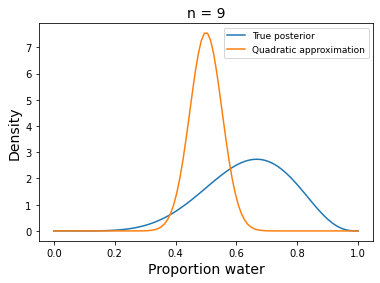

In [60]:
w, n = 6, 9
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x , w+1, n-w+1),
         label='True posterior')

# quadratic approximation
plt.plot(x, stats.norm.pdf(x, mean_q['prior'], std_q),
         label='Quadratic approximation')
plt.legend(loc=0, fontsize=9)

plt.title('n = {}'.format(n), fontsize=14)
plt.xlabel('Proportion water', fontsize=14)
plt.ylabel('Density', fontsize=14);

#TODO: something's wrong here